In [1]:
## Imports
import numpy as np
import torch
from PIL import Image
import cv2
from torch.nn import functional as F
import einops
from utils.models.factory import create_model_and_transforms, get_tokenizer
from utils.misc.visualization import image_grid, visualization_preprocess
from utils.models.prs_hook import hook_prs_logger    # Logger for applying hook to model
from matplotlib import pyplot as plt
from utils.scripts.algorithms_text_explanations_funcs import *
from utils.datasets_constants.imagenet_classes import imagenet_classes
from utils.datasets_constants.cifar_10_classes import cifar_10_classes
from utils.datasets_constants.cub_classes import cub_classes, waterbird_classes
import os
import timm

/home/ggil/anaconda3/envs/MT/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ggil/anaconda3/envs/MT/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
## Parameters
device = 'cpu'
model_name = 'ViT-B-32' # 'ViT-H-14'
seed = 0
num_last_layers_ = 4
subset_dim = None
tot_samples_per_class = None
dataset_text_name = "top_1500_nouns_5_sentences_imagenet_clean"
datataset_image_name = "binary_waterbirds"
algorithm = "svd_data_approx"
path = './datasets/'

if model_name == "ViT-H-14":
    pretrained = "laion2B-s32B-b79K"
elif model_name == "ViT-L-14":
    pretrained = "laion2B-s32B-b82K"
elif model_name == "ViT-B-16":
    pretrained = "laion2B-s34B-b88K"
elif model_name == "ViT-B-32":
    pretrained = "laion2B-s34B-b79K"

In [3]:
## Loading Model
model, _, preprocess = create_model_and_transforms(model_name, pretrained=pretrained, cache_dir="../cache")
model.to(device)
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size
tokenizer = get_tokenizer(model_name)

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)
print("Len of res:", len(model.visual.transformer.resblocks))

prs = hook_prs_logger(model, device, spatial=True) # This attach hook to get the residual stream

Using local files


/home/ggil/ETHZ/MT2024/utils/models/factory.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map_location)


Model parameters: 151,277,313
Context length: 77
Vocab size: 49408
Len of res: 12


In [4]:
# Load the new created attention datasets
attention_dataset = f"output_dir/{datataset_image_name}_completeness_{dataset_text_name}_{model_name}_algo_{algorithm}_seed_{seed}.jsonl"

# Load necessary data
attns_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_attn_{model_name}_seed_{seed}.npy", mmap_mode="r"))  # [b, l, h, d], attention values
mlps_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_mlp_{model_name}_seed_{seed}.npy", mmap_mode="r"))  # [b, l, h, d], mlp values
classifier_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_classifier_{model_name}.npy", mmap_mode="r"))  # [b, l, h, d], embedding of the labels
labels_ = torch.tensor(np.load(f"output_dir/{datataset_image_name}_labels_{model_name}_seed_{seed}.npy", mmap_mode="r")) # Position of the labels in the cosndiered dataset
final_embeddings_images = torch.tensor(np.load(f"output_dir/{datataset_image_name}_embeddings_{model_name}_seed_{seed}.npy", mmap_mode="r"))
final_embeddings_texts = torch.tensor(np.load(f"output_dir/{dataset_text_name}_{model_name}.npy", mmap_mode="r"))
with open( f"utils/text_descriptions/{dataset_text_name}.txt", "r") as f:
    texts_str = np.array([i.replace("\n", "") for i in f.readlines()])
# Get mean ablation
no_heads_attentions_ = attns_.sum(axis=(2))  # Sum over heads dimension
last_ = attns_.shape[1] - num_last_layers_
# Replace attention activations until 'last' layer with their average, while keeping later layers intact.
current_mean_ablation_per_head_sum_ = torch.mean(no_heads_attentions_[:, :last_ + 1], axis=0).sum(0)

# Save important stuff
nr_layers_ = attns_.shape[1]
nr_heads_ = attns_.shape[2]

if datataset_image_name == "imagenet":
    ds_ = ImageNet(root=path+"imagenet/", split="val", transform=visualization_preprocess)
elif datataset_image_name == "binary_waterbirds":
    ds_ = BinaryWaterbirds(root=path+"waterbird_complete95_forest2water2/", split="test", transform=visualization_preprocess)
elif datataset_image_name == "CIFAR100":
    ds_ = CIFAR100(
        root=path, download=True, train=False, transform=visualization_preprocess
    )
elif datataset_image_name == "CIFAR10":
    ds_ = CIFAR10(
        root=path, download=True, train=False, transform=visualization_preprocess
    )
else:
    ds_ = ImageFolder(root=path, transform=visualization_preprocess)

classes_ = {
        'imagenet': imagenet_classes, 
        'CIFAR10': cifar_10_classes,
        'waterbirds': cub_classes, 
        'binary_waterbirds': waterbird_classes, 
        'cub': cub_classes}[datataset_image_name]
# Depending
ds_vis_ = dataset_subset(
    ds_,
    samples_per_class=subset_dim,
    tot_samples_per_class=tot_samples_per_class,  # or whatever you prefer
    seed=seed,
)

# Print metadata accuracy if waterbird
if classes_ == waterbird_classes:
    root = "datasets/waterbird_complete95_forest2water2/"
    df = pd.read_csv(root + "metadata.csv")
    filtered_df = df[df['split'] == 2]

    s = [(os.path.join(root, filtered_df.iloc[i]['img_filename']), filtered_df.iloc[i]['y'], filtered_df.iloc[i]['place']) for i in range(len(filtered_df))]
    background_groups_ = list([x[2] for x in s])

# Retrieve Rank
data = get_data(attention_dataset, skip_final=True)
mean_rank_ = 0
for entry in data:
    mean_rank_ += entry["rank"]
mean_rank_ /= len(data)

Full dataset


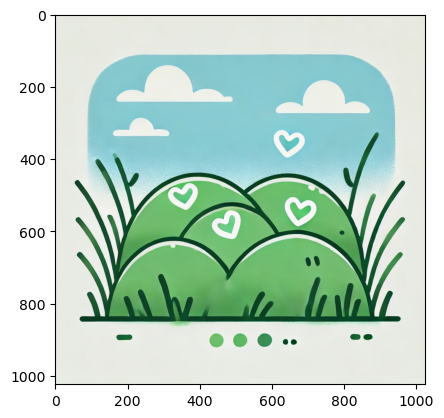

In [5]:
## Load image
image_pil = Image.open('images/heart.png')
image = preprocess(image_pil)[np.newaxis, :, :, :]
_ = plt.imshow(image_pil)

In [6]:
## Run the image and compute attentions and mlps
prs.reinit()
with torch.no_grad():
    # Get the embedding of the image
    representation = model.encode_image(image.to(device), 
                                        attn_method='head', # get patch contribution per fixed head
                                        normalize=False)
    attentions, mlps = prs.finalize(representation)  # attentions: [1, 12, 197, 16, 512], [b, l, n, h, d], mlps: [1, 13, 512], [b, l + 1, d]
    attentions = einops.rearrange(attentions, "b l n h d -> b l h n d")
    print(attentions.shape, mlps.shape)

torch.Size([1, 12, 12, 50, 512]) torch.Size([1, 13, 512])


## Visualize token decomposition on full output

In [ ]:
## Get the texts
lines = ["heart"]
texts = tokenizer(lines).to(device)  # tokenize text for encoder
class_embeddings = model.encode_text(texts)
print(class_embeddings.shape)
print(attentions[0, :, :, 1:].sum(axis=(0,1)).shape)

torch.Size([1, 512])
torch.Size([49, 512])


In [13]:
def plot_segment_map(attentions, class_embeddings, image_pil, lines, device, layer=None, head=None):
    """
    Generate and display zero-shot segmentation maps for an arbitrary number of text embeddings.
    
    Parameters:
        attentions (torch.Tensor): Attention maps from the model with shape [B, heads, tokens, tokens].
                                   (Assumed that the first token is the CLS token.)
        class_embeddings (torch.Tensor): Text embeddings for each class with shape [num_classes, embed_dim].
        image_pil (PIL.Image): The original image (as a PIL image) on which to overlay the segmentation maps.
        model: The model object (used here to get the patch size).
        device: The torch device to perform interpolation on.
        lines: class_names (list of strings)
    """
    
    # 1. Compose the attention map.
    #    Skip the first token (CLS), sum over heads and remaining tokens,
    #    then perform a dot product with the text embeddings (transposed) to get one score per patch per class.
    #    Shape: [num_patches, num_classes]
    if layer is None:
        attention_map = attentions[0, :, :, 1:].sum(axis=(0, 1)) @ class_embeddings.T
    else:
        if head is None:
            attention_map = attentions[0, layer, :, 1:].sum(axis=(0)) @ class_embeddings.T
        else:
            attention_map = attentions[0, layer, head, 1:] @ class_embeddings.T

    # 2. Recover the spatial dimensions of the patches.
    num_patches = attention_map.shape[0]
    # Assuming a square grid of patches (this works for most vision transformer models)
    dim_patch = int(np.sqrt(num_patches))

    # 3. Rearrange the flat attention map into [1, num_classes, height, width]
    #    and upscale it to the original image resolution.
    attention_map = einops.rearrange(attention_map, '(N M) C -> 1 C N M', N=dim_patch, M=dim_patch)
    # Get original image size; note that PIL returns (width, height)
    width, height = image_pil.size  
    attention_map = F.interpolate(
        attention_map,
        size=(height, width),  # F.interpolate expects size as (H, W)
        mode='bilinear'
    ).to(device)
    
    # Detach and convert to NumPy for visualization.
    # Now attention_map has shape [num_classes, H, W]
    attention_map = attention_map[0].detach().cpu().numpy()
    
    num_classes = attention_map.shape[0]
    
    # 4. Use the attention map directly as the difference map.
    difference_maps = attention_map

    # 5. Normalize globally (across all classes) for consistent color scaling.
    global_min = difference_maps.min()
    global_max = difference_maps.max()
    
    # 6. Plot the overlay for each class.
    for i in range(num_classes):
        diff = difference_maps[i]
        # Avoid division by zero in case global_max equals global_min.
        if global_max - global_min > 0:
            normalized = (diff - global_min) / (global_max - global_min)
        else:
            normalized = np.zeros_like(diff)
        
        # Now `normalized` has values between 0 and 1.
        plt.figure()
        plt.imshow(image_pil)
        # Overlay the normalized map using a colormap with fixed vmin/vmax to [0, 1]
        plt.imshow(normalized, cmap='jet', alpha=0.8, vmin=0, vmax=1)
        plt.title(f"Class {lines[i]} Segmentation")
        plt.colorbar()  # This colorbar will now reflect values between 0 and 1.
        plt.axis('off')
        plt.show()

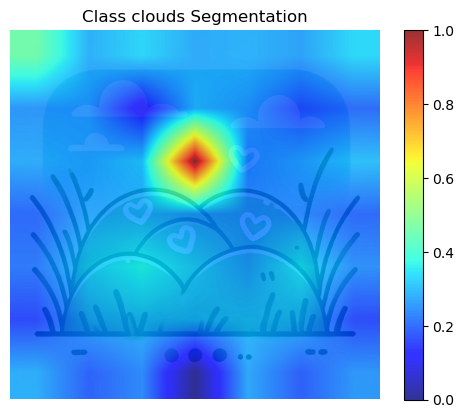

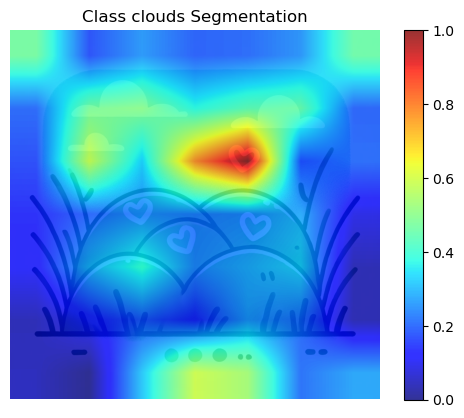

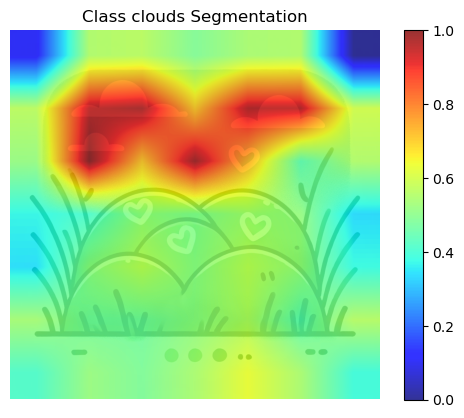

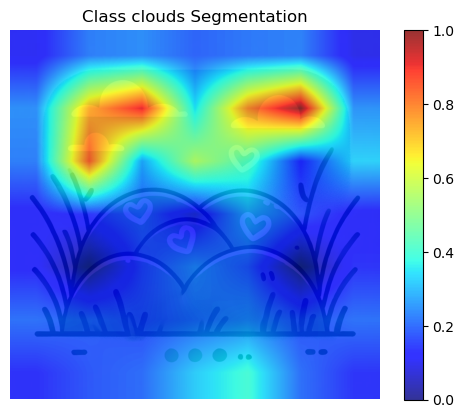

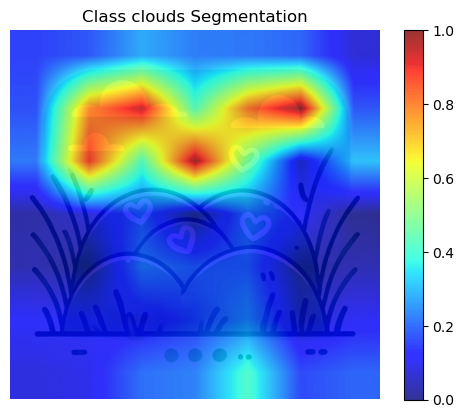

In [14]:
# Plot last layers
num_last_layers_plot = 4
for k in range(nr_layers_ - num_last_layers_, nr_layers_):
    plot_segment_map(attentions, class_embeddings, image_pil, lines, device, layer=k)
plot_segment_map(attentions, class_embeddings, image_pil, lines, device)

## Visualize token decomposition on partial output

In [10]:
# Parameters if want to look at specific head or pcs
layer = 11
head = 7
pc = 0

# General parameters
max_pcs_per_head = -1
num_last_layers_plot = 4
pcs_per_class = 1100
embedding = mlps.sum(axis=(1)) + attentions.sum(axis=(1, 2, 3)) 

# Parameters to decide what to do
look_at_pc = False
look_at_head = False
mean_of_pc = False
query_system = True
all_layer = False
remove_concept = True

# Parameters if we want to look at other concepts e.g. when removing one
check_other_concept = True
other_concept = ["clouds"]


Currently processing label heart with nr_pcs_per_class: 1100
Heads to keep:  48


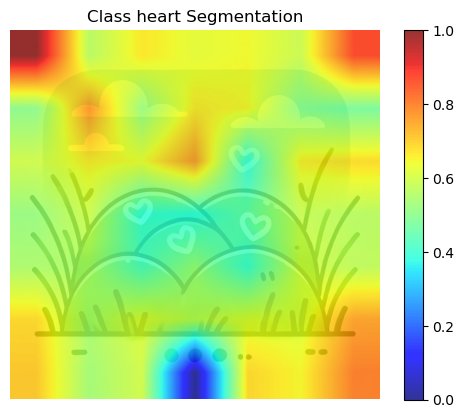

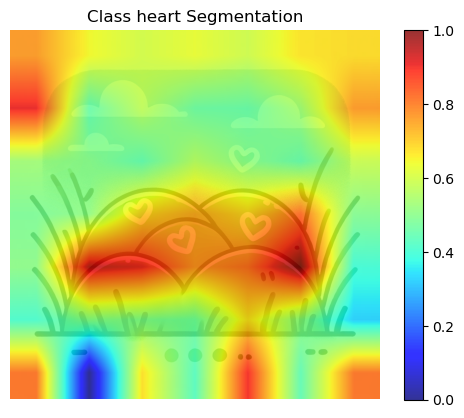

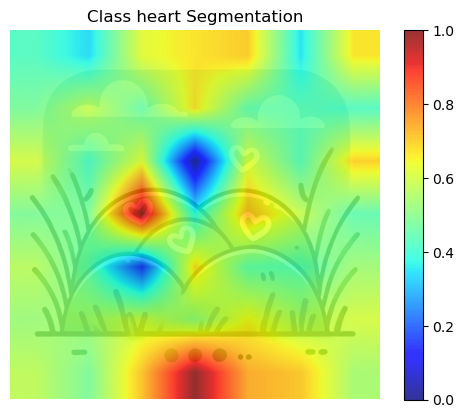

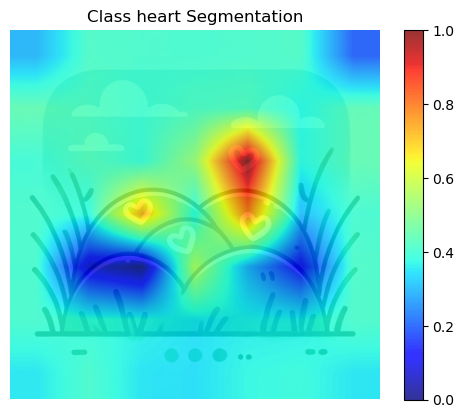

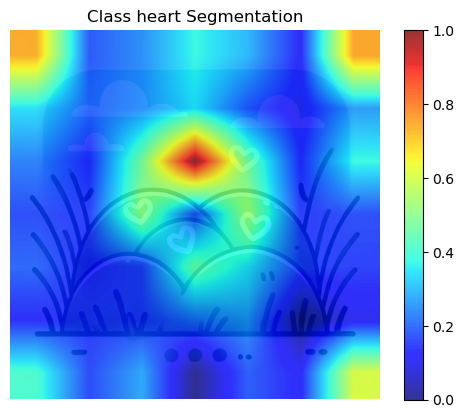


CHECK OTHER CONCEPTS



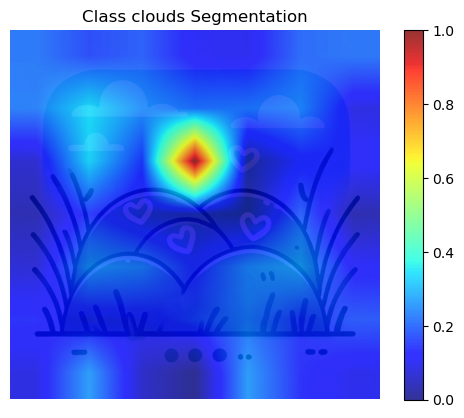

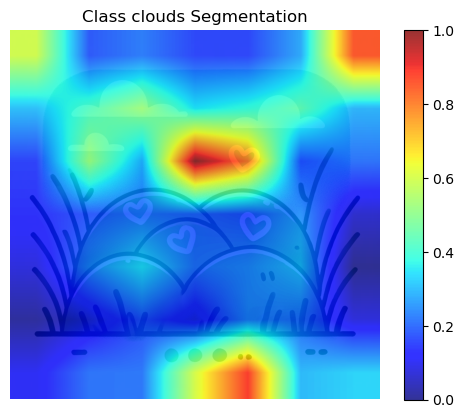

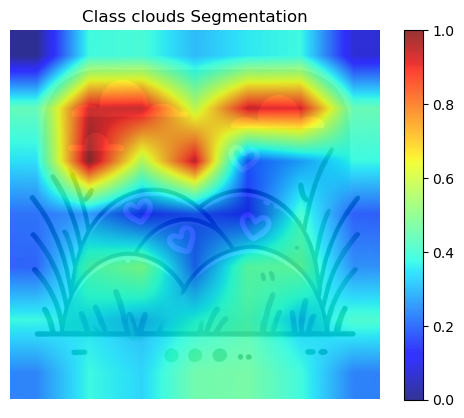

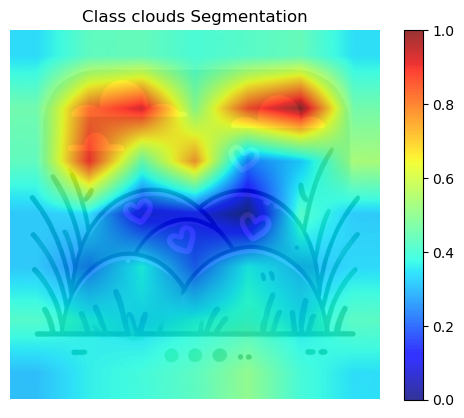

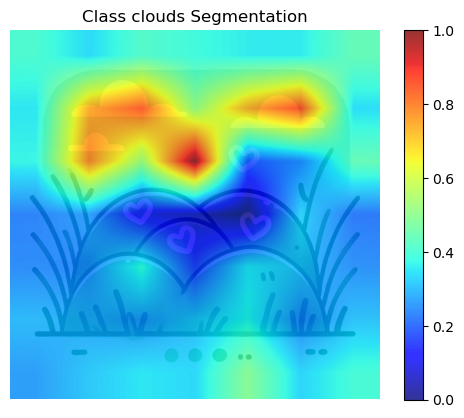

In [11]:
# Call the function early on to print the configuration summary.
data = get_data(attention_dataset, max_pcs_per_head, skip_final=True)
# Decide where to look at
if look_at_pc:
    data = get_data_component(data, layer, head, pc)
elif look_at_head:
    data = get_data_head(data, layer, head)
# Whether to use the query system or not
elif query_system:
    # Patch model if needed
    mean_final_texts = torch.mean(final_embeddings_texts, axis=0)
    classes_centered = class_embeddings - mean_final_texts.unsqueeze(0)
    sorted_data = []
    for text_idx in range(classes_centered.shape[0]):
        # Perform query system on entry
        concept_i_centered = classes_centered[text_idx, :].unsqueeze(0)

        data = get_data(attention_dataset, max_pcs_per_head, skip_final=True)

        _, data_abs = reconstruct_embeddings(
            data, 
            [concept_i_centered], 
            ["text"], 
            return_princ_comp=True, 
            plot=False, 
            means=[mean_final_texts],
        )

        # Extract relevant details from the top k entries
        data_pcs = sort_data_by(data_abs, "correlation_princ_comp_abs", descending=True)
        top_k_entries = top_data(data_pcs, pcs_per_class)
             
        # Derive nr_pcs_per_class
        sorted_data += top_k_entries
        print(f"Currently processing label {lines[text_idx]} with nr_pcs_per_class: {pcs_per_class}")


    # Remove duplicates
    entries_set = []
    entries_meta = []
    for entry in sorted_data:
        layer = entry["layer"]
        head = entry["head"]
        princ_comp = entry["princ_comp"]
        if (layer, head, princ_comp) not in entries_meta:
            entries_meta.append((layer, head, princ_comp))
            entries_set.append(entry)

    if remove_concept:
        entries_set = get_remaining_pcs(data, entries_set)

    attentions_rec = reconstruct_all_embeddings_mean_ablation_pcs(
        entries_set,
        mlps,
        attentions,
        attns_,
        nr_layers_,
        nr_heads_,
        num_last_layers_,
        ratio=-1,
        mean_ablate_all=False, 
        return_attention=True
    )

else:
    entries_set = top_data(data, pcs_per_class)

    attentions_rec = reconstruct_all_embeddings_mean_ablation_pcs(
        entries_set,
        mlps,
        attentions,
        attns_,
        nr_layers_,
        nr_heads_,
        num_last_layers_,
        ratio=-1,
        mean_ablate_all=False, 
        return_attention=True
    )

# Plot different layers and the final aggregation contribution
for k in range(nr_layers_ - num_last_layers_, nr_layers_):
        plot_segment_map(attentions_rec, class_embeddings, image_pil, lines, device, layer=k)
plot_segment_map(attentions_rec, class_embeddings, image_pil, lines, device)
# Check other concept if requested
if check_other_concept:
    print("\nCHECK OTHER CONCEPTS\n")
    ## Get the texts
    texts = tokenizer(other_concept).to(device)  # tokenize text for encoder
    class_embeddings_other = model.encode_text(texts)
    for k in range(nr_layers_ - num_last_layers_, nr_layers_):
        plot_segment_map(attentions_rec, class_embeddings_other, image_pil, other_concept, device, layer=k)
    plot_segment_map(attentions_rec, class_embeddings_other, image_pil, other_concept, device)
